In [19]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap

from src.get_project_data import locale_data, _AUSTIN_AREA_ZIP_CODES

### Data Sources for mapping

These plots require shape files downloaded from the Census. They are very large so you will need to download them yourself and change the paths below.
- [ZCTA Files](https://www2.census.gov/geo/tiger/TIGER2020/ZCTA520/) 504MB
- [County Files](https://www2.census.gov/geo/tiger/TIGER2020/COUNTY/) 77MB
- [State Files](https://www2.census.gov/geo/tiger/TIGER2020/STATE/) 9.3MB

For Cities in Texas you will need a (much smaller) txt file also from the Census.
- [2020_gaz_place_48.txt](https://www2.census.gov/geo/docs/maps-data/data/gazetteer/2020_Gazetteer/2020_gaz_place_48.txt)

In [ ]:
# File Paths
ZCTA_Shape_Files = r'C:\Users\Zachary\Downloads\tl_2020_us_zcta520\tl_2020_us_zcta520.shp'
County_Shape_Files = r'C:\Users\Zachary\Downloads\tl_2020_us_county\tl_2020_us_county.shp'
State_Shape_Files = r"C:\Users\Zachary\Downloads\tl_2020_us_state\tl_2020_us_state.shp"

Places_Text_File = r"C:\Users\Zachary\Downloads\2020_gaz_place_48.txt"

In [2]:
# Zip Code (ZCTA) Shape File
df_zipcodes = gpd.read_file(ZCTA_Shape_Files)
df_zipcodes.rename(columns={'ZCTA5CE20':'zipcode'}, inplace=True)
df_zipcodes["zipcode"] = df_zipcodes["zipcode"].astype(int)
# County Shape File
df_county = gpd.read_file(County_Shape_Files)
df_county["STATEFP"] = df_county["STATEFP"].astype(int)
# State Shape File
df_state = gpd.read_file(State_Shape_Files)
df_state[["REGION", "DIVISION", "STATEFP"]] = df_state[["REGION", "DIVISION", "STATEFP"]].astype(int)

In [3]:
# Texas zipcode data
df_locale = locale_data()
df_tx_zipcodes = df_zipcodes[df_zipcodes["zipcode"].between(75000, 79999)]

In [4]:
# Create color map of locale types
land_color_list = ["#eb348c", "#fc4eda", "#e880ff",  # urban
                   "#ff9a26", "#fac852", "#fff759",  # suburban
                   "#1a2ca3", "#5477de", "#6cade6",  # town
                   "#85ed7b", "#59c24f", "#2e8f25",  # rural
                   ]
land_color_map = ListedColormap(land_color_list)

In [5]:
tx_zip_land_data = df_tx_zipcodes.merge(df_locale, on="zipcode")
tx_zip_land_data["LOCALE"] = tx_zip_land_data["LOCALE"].astype(int)
print("Shape", tx_zip_land_data.shape)
print(tx_zip_land_data.dtypes)
tx_zip_land_data["LOCALE"] = tx_zip_land_data["LOCALE"].map({11: 1, 12: 2, 13: 3,
                                                             21: 4, 22: 5, 23: 6,
                                                             31: 7, 32: 8, 33: 9,
                                                             41: 10, 42: 11, 43: 12})
tx_zip_land_data.head()

Shape (1989, 11)
zipcode          int32
GEOID20         object
CLASSFP20       object
MTFCC20         object
FUNCSTAT20      object
ALAND20          int64
AWATER20         int64
INTPTLAT20      object
INTPTLON20      object
geometry      geometry
LOCALE           int32
dtype: object


,zipcode,GEOID20,CLASSFP20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry,LOCALE
0,79835,79835,B5,G6350,S,22937438,417567,+31.9356531,-106.5960888,"POLYGON ((-106.62974 31.92657, -106.62857 31.9...",10
1,79837,79837,B5,G6350,S,2816585533,13321362,+32.0952608,-105.1624069,"POLYGON ((-105.66123 32.22545, -105.66122 32.2...",12
2,79922,79922,B5,G6350,S,20868598,220641,+31.8103693,-106.5559638,"POLYGON ((-106.60569 31.84623, -106.60531 31.8...",1
3,77044,77044,B5,G6350,S,101257280,19516586,+29.9063122,-095.1805606,"POLYGON ((-95.24057 29.89875, -95.23708 29.902...",10
4,77059,77059,B5,G6350,S,23915816,153131,+29.6135284,-095.1186666,"POLYGON ((-95.15403 29.62699, -95.15390 29.626...",1


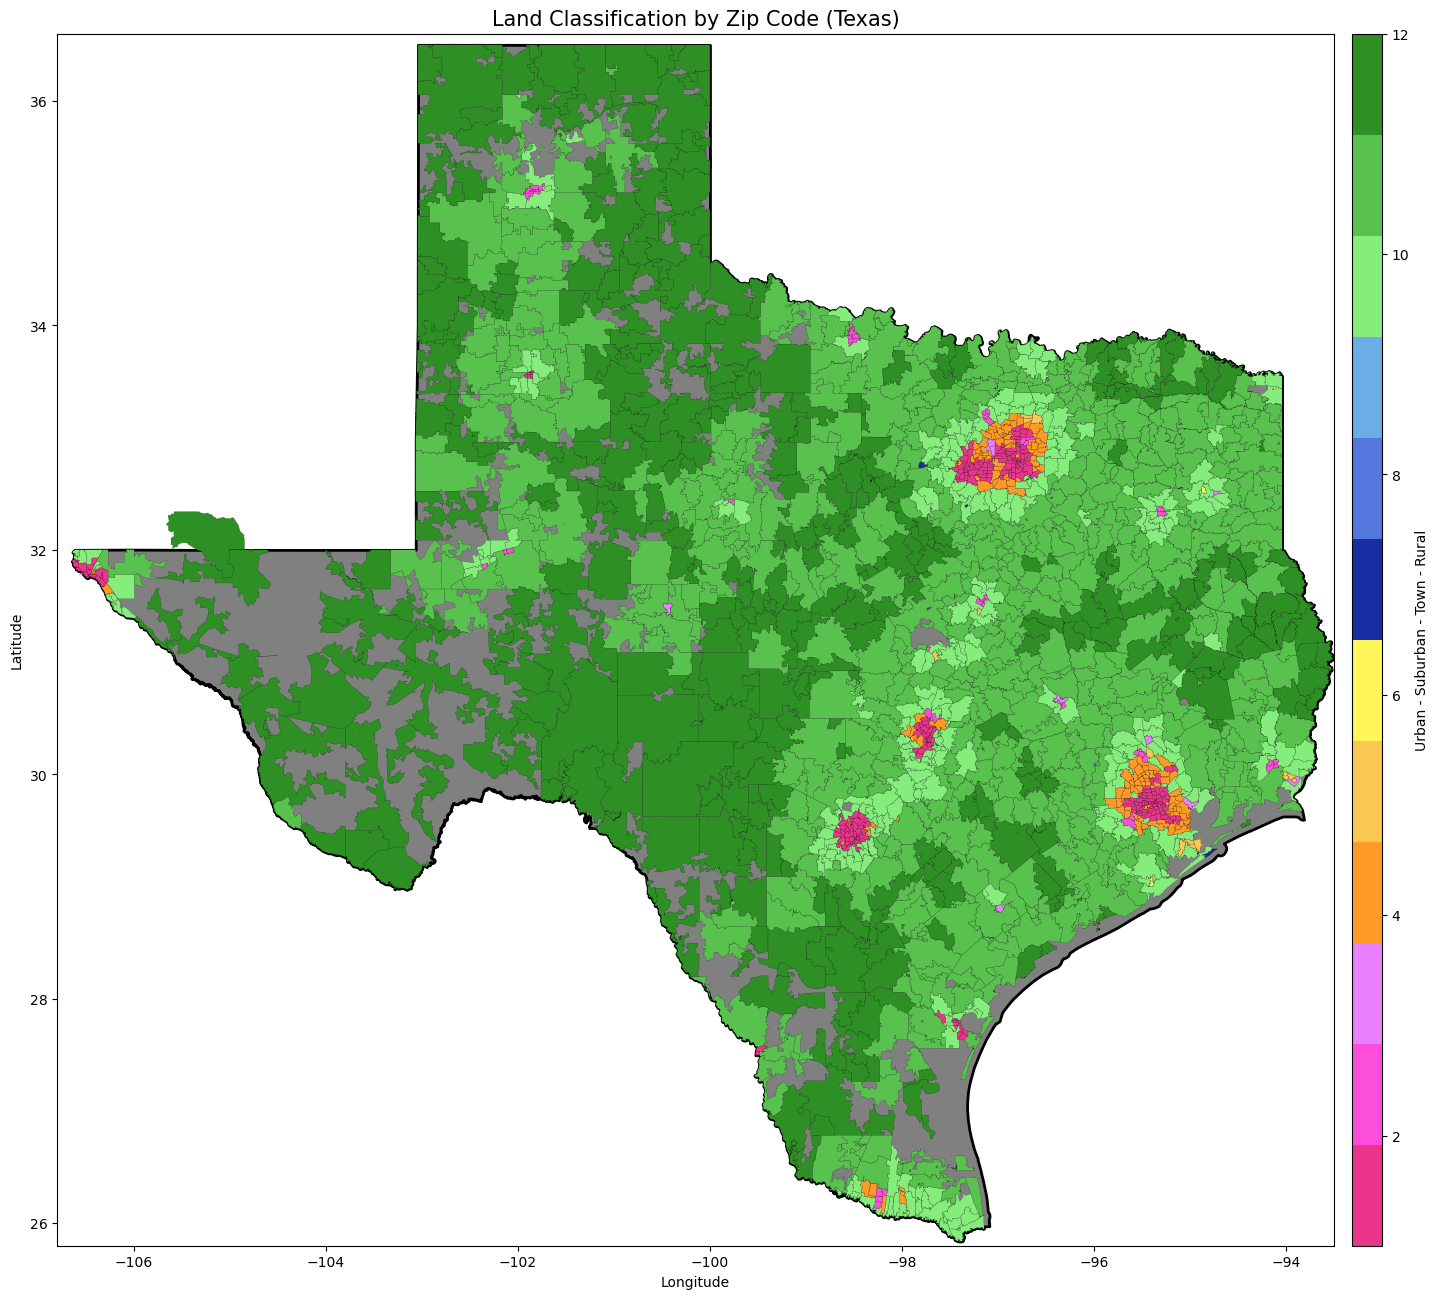

In [39]:
# see https://geopandas.org/en/latest/docs/user_guide/mapping.html
fig, ax = plt.subplots(figsize=(15, 15))
plt.subplots_adjust(left=0.04, right=0.995, top=0.96, bottom=0.08)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=-0.9)
base = df_state[df_state["STATEFP"] == 48].plot(ax=ax, color="gray", edgecolor='black', linewidth=2)
tx_zip_land_data.plot(ax=ax,
                      column='LOCALE',
                      edgecolor="black",
                      linewidth=0.1,
                      cmap=land_color_map,
                      vmin=1,
                      vmax=12,
                      legend=True,
                      cax=cax,
                      legend_kwds={'label': "Urban - Suburban - Town - Rural", 'orientation': "vertical"})
ax.set_title("Land Classification by Zip Code (Texas)", fontdict={"size": 15})
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-106.8, -93.5)
ax.set_ylim(25.8, 36.6)
plt.show()

## Greater Austin Area Map

In [20]:
# Cities in Austin Area GeoDataFrame
df_tx_census_places = pd.read_csv(Places_Text_File, delimiter="\t")
# fix bad column names
df_tx_census_places.rename(columns={"INTPTLAT": "Latitude",
                                    "INTPTLONG                                                                                                 ": "Longitude"},
                                    inplace=True)
df_tx_census_cities = df_tx_census_places[(df_tx_census_places["NAME"].str.endswith(" city")) & (df_tx_census_places["ALAND"] > 65_000_000)]  # cities with large land area
df_tx_census_cities["NAME"] = df_tx_census_cities["NAME"].str.rstrip("city")
gdf_tx_cities = gpd.GeoDataFrame(df_tx_census_cities,
                                 geometry=gpd.points_from_xy(df_tx_census_cities["Longitude"], df_tx_census_cities["Latitude"]))
gdf_tx_cities.head()

C:\Users\Zachary\AppData\Local\Temp\ipykernel_2796\2669941280.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tx_census_cities["NAME"] = df_tx_census_cities["NAME"].str.rstrip("city")


,USPS,GEOID,ANSICODE,NAME,LSAD,FUNCSTAT,ALAND,AWATER,ALAND_SQMI,AWATER_SQMI,Latitude,Longitude,geometry
2,TX,4801000,2409657,Abilene,25,A,276270544,14051306,106.669,5.425,32.454514,-99.738147,POINT (-99.73815 32.45451)
24,TX,4801924,2409684,Allen,25,A,68374802,222371,26.400,0.086,33.109736,-96.673032,POINT (-96.67303 33.10974)
36,TX,4803000,2409694,Amarillo,25,A,264965709,4029011,102.304,1.556,35.198921,-101.831647,POINT (-101.83165 35.19892)
61,TX,4804000,2409731,Arlington,25,A,248289586,9329197,95.865,3.602,32.700708,-97.124691,POINT (-97.12469 32.70071)
72,TX,4805000,2409761,Austin,25,A,828633626,17024681,319.937,6.573,30.301157,-97.752695,POINT (-97.75270 30.30116)


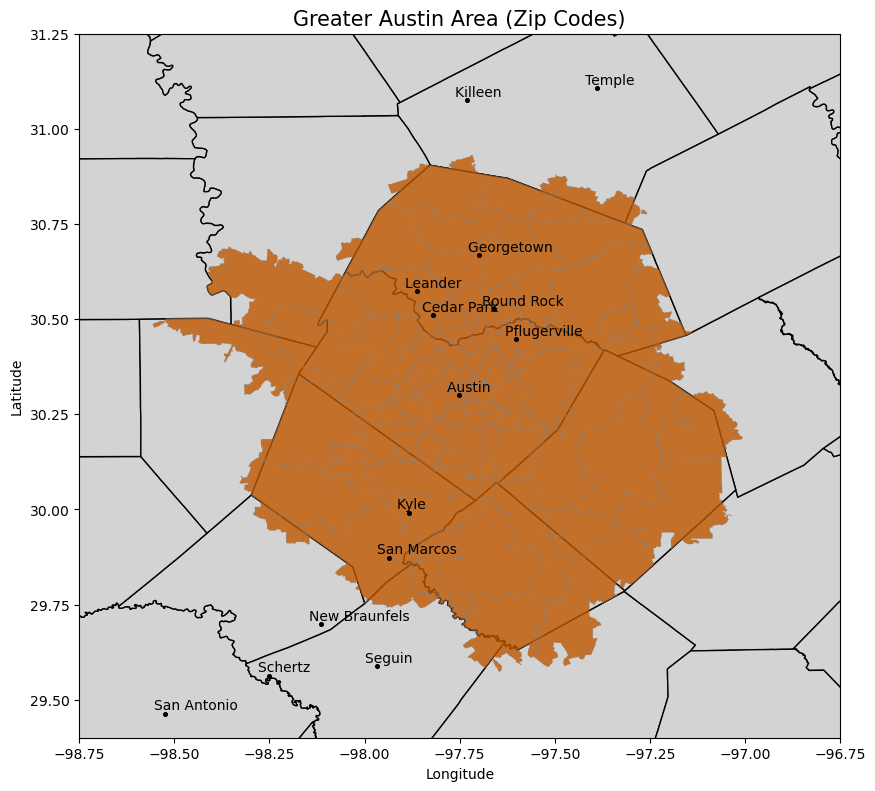

In [31]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.subplots_adjust(left=0.04, right=0.995, top=0.96, bottom=0.08)
base_county = df_county[df_county["STATEFP"] == 48].plot(ax=ax, color="lightgray", edgecolor='black')
df_zipcodes[df_zipcodes["zipcode"].isin(_AUSTIN_AREA_ZIP_CODES)].plot(ax=ax, color="#bf5700", edgecolor="gray", linewidth=0.3, alpha=0.8)
# City Names
gdf_tx_cities.plot(ax=ax, color='black', markersize=7)
for idx, city_data in gdf_tx_cities.iterrows():
    ax.annotate(city_data["NAME"], (city_data["Longitude"]-.03, city_data["Latitude"]+.01))
ax.set_title("Greater Austin Area (Zip Codes)", fontdict={"size": 15})
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_xlim(-98.75, -96.75)
ax.set_ylim(29.4, 31.25)
plt.show()